In [1]:
from IPython.display import Image
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [115]:
import os
import itertools
import termcolor
from termcolor import colored

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import pylab

from collections import defaultdict
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

In [116]:
def read_file(filename):
        string = open(filename, "r").read()
        string_list = string.split("\n")
        string_list = [line for line in string_list if line and line[0] != '#'] #Read line only if it is nonempty and not a comment.
        return string_list

In [117]:
eval_by_nctg = '../eval/'
eval_by_len = '../eval/'

In [118]:
EFAECIUM = [15,16]
ECOLI = [18,19,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,52]
KPNEUMONIAE = [62,64,65,66,76,85,86,87]
OTHER = [1,5,55,56,102,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,129,133]

#LEFTOUT = [31,55]

In [119]:
#Overall stats; key:sample_id, values: precision, recall, f1, total_length
PBF_STATS = {}
PB_STATS = {}
HYASP_STATS= {}
PLASMIDSPADES_STATS = {}
MOBSUITE_STATS = {}
GPLAS_STATS = {}

#Precision by sample; key:sample_id, values: precision_ratio, precision_by_length, total_length
PBF_PREC = {}
PB_PREC = {}
HYASP_PREC= {}
PLASMIDSPADES_PREC = {}
MOBSUITE_PREC = {}
GPLAS_PREC = {}

#Precision by plasmid; key: sample_id_plasmid_id, values: precision_ratio, precision_by_length, order of output, gene density, length
PBF_PREC_PLASMID = {}
PB_PREC_PLASMID = {}
HYASP_PREC_PLASMID= {}
PLASMIDSPADES_PREC_PLASMID = {}
MOBSUITE_PREC_PLASMID= {}
GPLAS_PREC_PLASMID = {}

#Recall by sample; key:sample_id, values: recall_ratio, recall_by_length
PBF_REC = {}
PB_REC = {}
HYASP_REC= {}
PLASMIDSPADES_REC = {}
MOBSUITE_REC = {}
GPLAS_REC = {}

#True plasmid length; key: plasmid_id, values: length
TP_LENGTH = {}

In [73]:
def read_eval_file(str_list, sample_id, eval_type):
    #print(str_list)
    #print(tool)
    #print(sample_id)
    stats = {}
    prec = {}
    prec_individual = {}
    rec = {}
    tp_length = {}

    delim = '>'
    delim_count = 0
    
     
    #Overall stats
    precision, recall, f1, total_len, pred_len = 0, 0, 0, 0, 0 
    
    for line in str_list:
        #print(line)
        if delim in line:
            delim_count += 1   
            #print(delim_count, line)
        
        if eval_type == 'len':
            #True plasmids & their lengths    
            if delim_count == 1:
                if 'nt' in line:
                    line = line.split("\t")
                    plas = line[0]
                    length = int(line[1].split(' ')[0])
                    tp_length[plas] = length
            #Predicted plasmids & their lengths       
            elif delim_count == 2:
                if 'nt' in line:
                    #print('delim_count 3', sample_id, plas)

                    line = line.split("\t")
                    plas = line[0]
                    length = int(line[1].split(' ')[0])
                    #output_order = int(plas.split('_')[1])
                    prec_individual['sample_'+sample_id+'_'+plas] = {}

                    #print('delim_count 3', sample_id, plas)
                    prec_individual['sample_'+sample_id+'_'+plas]['Length'] = length
                    #prec_individual['sample_'+sample_id+'_'+plas]['Order'] = output_order
                    prec_individual['sample_'+sample_id+'_'+plas]['Sample'] = sample_id
                
            #Precision per plasmid        
            elif delim_count == 3:
                if delim not in line:    
                    line = line.split("\t")
                    plas = line[0]
                    length = prec_individual['sample_'+sample_id+'_'+plas]['Length']
                    prec_individual['sample_'+sample_id+'_'+plas]['Precision_length'] = length*float(line[1])
                    prec_individual['sample_'+sample_id+'_'+plas]['Precision'] = float(line[1])
        
        #Final stats
        if delim_count == 5:
            #print('Final stats')
            if "Precision" in line:
                precision = float(line.split("\t")[1])
            if "Recall" in line:    
                recall = float(line.split("\t")[1])
            if "F1" in line:
                f1 = float(line.split("\t")[1])
            
            
            stats['Precision_by_'+eval_type] = precision
            prec['Precision_by_'+eval_type] = precision

            stats['Recall_by_'+eval_type] = recall
            rec['Recall_by_'+eval_type] = recall

            stats['F1_by_'+eval_type] = f1
            
            stats['Precision_by_nctg'] = 0
            stats['Recall_by_nctg'] = 0
            stats['F1_by_nctg'] = 0

        #Final weighted stats
        elif delim_count == 6:
            #print('Final weighted stats')
            if "Precision" in line:
                precision = float(line.split("\t")[1])
            stats['Precision_weighted'] = precision
            prec['Precision_weighted'] = precision
            if "Recall" in line:    
                recall = float(line.split("\t")[1])
            stats['Recall_weighted'] = recall
            rec['Recall_weighted'] = recall
            if "F1" in line:
                f1 = float(line.split("\t")[1])
            stats['F1_weighted'] = f1
        
    if eval_type == 'len':
        for p in tp_length:
            total_len += tp_length[p]
        stats['Length'] = total_len
        rec['Length'] = total_len
        rec['Recall_length'] = rec['Recall_weighted']*total_len  

        for p in prec_individual:
            pred_len += prec_individual[p]['Length']
        prec['Precision_length'] = prec['Precision_weighted']*pred_len   
        prec['Length'] = pred_len
        
    #print(prec_individual)    
            
    return stats, prec, rec, prec_individual, tp_length   

In [175]:
gplas_ids = EFAECIUM + ECOLI + KPNEUMONIAE
all_ids = gplas_ids + OTHER
sp_array = []
for i in all_ids:
    #print(i)
    if i in set(EFAECIUM):
        sp_array.append('E. faecium')
    elif i in set(ECOLI):
        sp_array.append('E. coli')
    elif i in set(KPNEUMONIAE):
        sp_array.append('K. pneumoniae')
    elif i == 1:
        sp_array.append('A. veronii')
    elif i == 5:
        sp_array.append('C. freundii')
    elif i == 55:
        sp_array.append('K. aerogenes')
    elif i == 56:
        sp_array.append('K. oxytoca')
    else:
        sp_array.append('S. enterica')
        
    sample_id = str(i)
    
    MOBSUITE_STATS[sample_id] = {}
    PBF_STATS[sample_id] = {}
    PB_STATS[sample_id] = {}
    HYASP_STATS[sample_id] = {}
    PLASMIDSPADES_STATS[sample_id] = {}
    GPLAS_STATS[sample_id] = {}
    
    
    mobsuite_eval_file = eval_by_len+'sample_'+sample_id+'/mob_recon_wtd_eval_st100.csv'
    str_list = read_file(mobsuite_eval_file)    
    prec_len, rec_len, f1_len = float(str_list[-3].split('\t')[1]), float(str_list[-2].split('\t')[1]), float(str_list[-1].split('\t')[1])
    MOBSUITE_STATS[sample_id]['Precision_by_len'] = prec_len
    MOBSUITE_STATS[sample_id]['Recall_by_len'] = rec_len
    MOBSUITE_STATS[sample_id]['F1_by_len'] = f1_len 

    #mobsuite_eval_file = eval_by_nctg+'sample_'+sample_id+'/mob_recon_eval.csv'
    mobsuite_eval_file = eval_by_nctg+'sample_'+sample_id+'/mob_recon_eval_st100.csv'
    str_list = read_file(mobsuite_eval_file)    
    #print(str_list[-4:])
    prec_nctg, rec_nctg, f1_nctg = float(str_list[-3].split('\t')[1]), float(str_list[-2].split('\t')[1]), float(str_list[-1].split('\t')[1])
    MOBSUITE_STATS[sample_id]['Precision_by_nctg'] = prec_nctg
    MOBSUITE_STATS[sample_id]['Recall_by_nctg'] = rec_nctg
    MOBSUITE_STATS[sample_id]['F1_by_nctg'] = f1_nctg 
    
    
    plasmidspades_eval_file = eval_by_len+'sample_'+sample_id+'/psp_wtd_eval_st100.csv'
    str_list = read_file(plasmidspades_eval_file)    
    prec_len, rec_len, f1_len = float(str_list[-3].split('\t')[1]), float(str_list[-2].split('\t')[1]), float(str_list[-1].split('\t')[1])
    PLASMIDSPADES_STATS[sample_id]['Precision_by_len'] = prec_len
    PLASMIDSPADES_STATS[sample_id]['Recall_by_len'] = rec_len
    PLASMIDSPADES_STATS[sample_id]['F1_by_len'] = f1_len 

    #mobsuite_eval_file = eval_by_nctg+'sample_'+sample_id+'/mob_recon_eval.csv'
    plasmidspades_eval_file = eval_by_nctg+'sample_'+sample_id+'/psp_eval_st100.csv'
    str_list = read_file(plasmidspades_eval_file)    
    #print(str_list[-4:])
    prec_nctg, rec_nctg, f1_nctg = float(str_list[-3].split('\t')[1]), float(str_list[-2].split('\t')[1]), float(str_list[-1].split('\t')[1])
    PLASMIDSPADES_STATS[sample_id]['Precision_by_nctg'] = prec_nctg
    PLASMIDSPADES_STATS[sample_id]['Recall_by_nctg'] = rec_nctg
    PLASMIDSPADES_STATS[sample_id]['F1_by_nctg'] = f1_nctg 
    
    pbf_eval_file = eval_by_len+'sample_'+sample_id+'/pbf_wtd_eval_st100.csv'
    str_list = read_file(pbf_eval_file)
    prec_len, rec_len, f1_len = float(str_list[-3].split('\t')[1]), float(str_list[-2].split('\t')[1]), float(str_list[-1].split('\t')[1])
    PBF_STATS[sample_id]['Precision_by_len'] = prec_len
    PBF_STATS[sample_id]['Recall_by_len'] = rec_len
    PBF_STATS[sample_id]['F1_by_len'] = f1_len 
    #PBF_PREC_PLASMID.update(prec_sample)
    #TP_LENGTH.update(tplen_sample)
    
    #pbf_eval_file = eval_by_nctg+'sample_'+sample_id+'/pbf_eval.csv'
    pbf_eval_file = eval_by_nctg+'sample_'+sample_id+'/pbf_eval_st100.csv'
    str_list = read_file(pbf_eval_file)
    #print(str_list[-4:])
    prec_nctg, rec_nctg, f1_nctg = float(str_list[-3].split('\t')[1]), float(str_list[-2].split('\t')[1]), float(str_list[-1].split('\t')[1])
    PBF_STATS[sample_id]['Precision_by_nctg'] = prec_nctg
    PBF_STATS[sample_id]['Recall_by_nctg'] = rec_nctg
    PBF_STATS[sample_id]['F1_by_nctg'] = f1_nctg 
    
    pb_eval_file = eval_by_len+'sample_'+sample_id+'/pb_wtd_eval_st100.csv'
    str_list = read_file(pb_eval_file)
    prec_len, rec_len, f1_len = float(str_list[-3].split('\t')[1]), float(str_list[-2].split('\t')[1]), float(str_list[-1].split('\t')[1])
    PB_STATS[sample_id]['Precision_by_len'] = prec_len
    PB_STATS[sample_id]['Recall_by_len'] = rec_len
    PB_STATS[sample_id]['F1_by_len'] = f1_len 
    #PBF_PREC_PLASMID.update(prec_sample)
    #TP_LENGTH.update(tplen_sample)
    
    #pbf_eval_file = eval_by_nctg+'sample_'+sample_id+'/pbf_eval.csv'
    pb_eval_file = eval_by_nctg+'sample_'+sample_id+'/pb_eval_st100.csv'
    str_list = read_file(pb_eval_file)
    #print(str_list[-4:])
    prec_nctg, rec_nctg, f1_nctg = float(str_list[-3].split('\t')[1]), float(str_list[-2].split('\t')[1]), float(str_list[-1].split('\t')[1])
    PB_STATS[sample_id]['Precision_by_nctg'] = prec_nctg
    PB_STATS[sample_id]['Recall_by_nctg'] = rec_nctg
    PB_STATS[sample_id]['F1_by_nctg'] = f1_nctg 
    
    greedy_eval_file = eval_by_len+'sample_'+sample_id+'/hyasp_wtd_eval_st100.csv'
    str_list = read_file(greedy_eval_file)    
    prec_len, rec_len, f1_len = float(str_list[-3].split('\t')[1]), float(str_list[-2].split('\t')[1]), float(str_list[-1].split('\t')[1])
    HYASP_STATS[sample_id]['Precision_by_len'] = prec_len
    HYASP_STATS[sample_id]['Recall_by_len'] = rec_len
    HYASP_STATS[sample_id]['F1_by_len'] = f1_len 
    
    #greedy_eval_file = eval_by_nctg+'sample_'+sample_id+'/hyasp_eval.csv'
    greedy_eval_file = eval_by_nctg+'sample_'+sample_id+'/hyasp_eval_st100.csv'
    str_list = read_file(greedy_eval_file)
    #print(str_list[-4:])
    prec_nctg, rec_nctg, f1_nctg = float(str_list[-3].split('\t')[1]), float(str_list[-2].split('\t')[1]), float(str_list[-1].split('\t')[1])
    HYASP_STATS[sample_id]['Precision_by_nctg'] = prec_nctg
    HYASP_STATS[sample_id]['Recall_by_nctg'] = rec_nctg
    HYASP_STATS[sample_id]['F1_by_nctg'] = f1_nctg 
    
    if i in set(gplas_ids):
        gplas_eval_file = eval_by_len+'sample_'+sample_id+'/gplas_wtd_eval_st100.csv'
        str_list = read_file(gplas_eval_file)    
        #print(str_list[-4:])
        prec_len, rec_len, f1_len = float(str_list[-3].split('\t')[1]), float(str_list[-2].split('\t')[1]), float(str_list[-1].split('\t')[1])
        GPLAS_STATS[sample_id]['Precision_by_len'] = prec_len
        GPLAS_STATS[sample_id]['Recall_by_len'] = rec_len
        GPLAS_STATS[sample_id]['F1_by_len'] = f1_len

        #gplas_eval_file = eval_by_nctg+'sample_'+sample_id+'/gplas_eval.csv'
        gplas_eval_file = eval_by_nctg+'sample_'+sample_id+'/gplas_eval_st100.csv'
        str_list = read_file(gplas_eval_file)
        #print(str_list[-4:])
        prec_nctg, rec_nctg, f1_nctg = float(str_list[-3].split('\t')[1]), float(str_list[-2].split('\t')[1]), float(str_list[-1].split('\t')[1])
        GPLAS_STATS[sample_id]['Precision_by_nctg'] = prec_nctg
        GPLAS_STATS[sample_id]['Recall_by_nctg'] = rec_nctg
        GPLAS_STATS[sample_id]['F1_by_nctg'] = f1_nctg        
    #MILP_gd_file = results_folder+'sample_'+sample_id+'/1.1.1/MILP/MILP_putative_plasmids.fasta'
    #str_list = read_file(MILP_gd_file)
    
    #MILP_PREC_PLASMID = get_plasmid_gd(str_list, MILP_PREC_PLASMID, sample_id)
#print(MILP_PREC_PLASMID)    

In [178]:
GPLAS_DF = pd.DataFrame.from_dict(GPLAS_STATS).T
GPLAS_DF

,Precision_by_len,Recall_by_len,F1_by_len,Precision_by_nctg,Recall_by_nctg,F1_by_nctg
15,0.848642,0.282261,0.423624,0.860465,0.164948,0.276830
16,0.874696,0.714676,0.786630,0.785714,0.380000,0.512255
18,0.471915,0.472399,0.472157,0.533333,0.123077,0.200000
19,1.000000,0.378206,0.548838,1.000000,0.235294,0.380952
23,0.217972,0.806557,0.343195,0.250000,0.166667,0.200000
...,...,...,...,...,...,...
122,NaN,NaN,NaN,NaN,NaN,NaN
123,NaN,NaN,NaN,NaN,NaN,NaN
124,NaN,NaN,NaN,NaN,NaN,NaN
129,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
PBF_DF = pd.DataFrame.from_dict(PBF_STATS).T
PB_DF = pd.DataFrame.from_dict(PB_STATS).T
HYASP_DF = pd.DataFrame.from_dict(HYASP_STATS).T
PLASMIDSPADES_DF = pd.DataFrame.from_dict(PLASMIDSPADES_STATS).T
MOBSUITE_DF = pd.DataFrame.from_dict(MOBSUITE_STATS).T
GPLAS_DF = pd.DataFrame.from_dict(GPLAS_STATS).T

#PB_DF = PB_DF.drop(columns=['Length'])
#HYASP_DF = HYASP_DF.drop(columns=['Length'])
#PLASMIDSPADES_DF = PLASMIDSPADES_DF.drop(columns=['Length'])
#MOBSUITE_DF = MOBSUITE_DF.drop(columns=['Length'])
#GPLAS_DF = GPLAS_DF.drop(columns=['Length'])

def rename_columns(df, tool):
    df.columns = df.columns.str.replace('Precision', tool+'_Prec')
    df.columns = df.columns.str.replace('Recall', tool+'_Rec')
    df.columns = df.columns.str.replace('F1', tool+'_F1')
    return df

PB_DF = rename_columns(PB_DF, 'plasbin')
HYASP_DF = rename_columns(HYASP_DF, 'greedy')
PLASMIDSPADES_DF = rename_columns(PLASMIDSPADES_DF, 'plasmidspades')
MOBSUITE_DF = rename_columns(MOBSUITE_DF, 'mobrecon')
GPLAS_DF = rename_columns(GPLAS_DF, 'gplas')


#PLASMIDSPADES_DF = PLASMIDSPADES_DF.rename(columns={"Precision": "plasmidspades_Precision", "Recall": "plasmidspades_Recall", "F1": "plasmidspades_F1"})
#MOBSUITE_DF = MOBSUITE_DF.rename(columns={"Precision": "mobsuite_Precision", "Recall": "mobsuite_Recall", "F1": "mobsuite_F1"})
#GPLAS_DF = GPLAS_DF.rename(columns={"Precision": "gplas_Precision", "Recall": "gplas_Recall", "F1": "gplas_F1"})

ALL_DF = PBF_DF.join(PB_DF)
ALL_DF = ALL_DF.join(HYASP_DF)
ALL_DF = ALL_DF.join(PLASMIDSPADES_DF)
ALL_DF = ALL_DF.join(MOBSUITE_DF)
ALL_DF = pd.concat([ALL_DF, GPLAS_DF], axis=1)

In [180]:
ALL_DF

,Precision_by_len,Recall_by_len,F1_by_len,Precision_by_nctg,Recall_by_nctg,F1_by_nctg,plasbin_Prec_by_len,plasbin_Rec_by_len,plasbin_F1_by_len,plasbin_Prec_by_nctg,...,mobrecon_F1_by_len,mobrecon_Prec_by_nctg,mobrecon_Rec_by_nctg,mobrecon_F1_by_nctg,gplas_Prec_by_len,gplas_Rec_by_len,gplas_F1_by_len,gplas_Prec_by_nctg,gplas_Rec_by_nctg,gplas_F1_by_nctg
15,0.778199,0.558613,0.650371,0.881944,0.608247,0.719962,0.628688,0.325468,0.428898,0.868613,...,0.876182,0.914286,0.659794,0.766467,0.848642,0.282261,0.423624,0.860465,0.164948,0.276830
16,0.663624,0.867280,0.751906,0.823529,0.800000,0.811594,0.543160,0.446091,0.489863,0.774510,...,0.892958,0.810811,0.560000,0.662461,0.874696,0.714676,0.786630,0.785714,0.380000,0.512255
18,0.213249,0.463852,0.292175,0.699360,0.515385,0.593441,0.552835,0.562998,0.557870,0.635036,...,0.492187,0.702703,0.126923,0.215011,0.471915,0.472399,0.472157,0.533333,0.123077,0.200000
19,0.906145,0.808944,0.854790,0.714286,0.529412,0.608108,0.673922,0.457405,0.544944,0.307692,...,0.960134,0.769231,0.588235,0.666667,1.000000,0.378206,0.548838,1.000000,0.235294,0.380952
23,0.166872,0.976801,0.285048,0.147059,0.500000,0.227273,0.017584,0.014550,0.015924,0.285714,...,0.534012,0.200000,0.166667,0.181818,0.217972,0.806557,0.343195,0.250000,0.166667,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,1.000000,0.947327,0.972951,1.000000,0.500000,0.666667,1.000000,0.052673,0.100074,1.000000,...,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
123,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
124,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
129,1.000000,0.511293,0.676630,1.000000,0.750000,0.857143,1.000000,0.418048,0.589611,1.000000,...,0.717255,1.000000,0.450000,0.620690,NaN,NaN,NaN,NaN,NaN,NaN


## Precision, Recall and F1

In [13]:
ALL_DF['Category'] = ALL_DF['Length']//100000
#print(sp_array)
ALL_DF['Species'] = sp_array

In [78]:
ALL_DF

,Precision_by_len,Recall_by_len,F1_by_len,Precision_by_nctg,Recall_by_nctg,F1_by_nctg,plasbin_Prec_by_len,plasbin_Rec_by_len,plasbin_F1_by_len,plasbin_Prec_by_nctg,...,mobrecon_F1_by_len,mobrecon_Prec_by_nctg,mobrecon_Rec_by_nctg,mobrecon_F1_by_nctg,gplas_Prec_by_len,gplas_Rec_by_len,gplas_F1_by_len,gplas_Prec_by_nctg,gplas_Rec_by_nctg,gplas_F1_by_nctg
15,1.000000,0.454087,0.624567,1.00000,0.600000,0.750000,1.0,0.335078,0.501960,1.0,...,0.670361,1.0,0.400000,0.571429,0.0,0.769589,0.000000,0.0,0.400000,0.000000
16,0.934802,0.877439,0.905212,0.83871,0.666667,0.742857,1.0,0.877439,0.934719,1.0,...,0.000000,0.0,0.333333,0.000000,0.0,0.754877,0.000000,0.0,0.333333,0.000000
18,1.000000,0.578904,0.733299,1.00000,0.600000,0.750000,1.0,0.719053,0.836569,1.0,...,0.000000,0.0,0.200000,0.000000,0.0,0.533302,0.000000,0.0,0.188235,0.000000
19,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.0,0.000000,0.000000,1.0,...,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000
23,0.000000,0.976458,0.000000,0.00000,0.400000,0.000000,0.0,0.000000,0.000000,0.0,...,0.900171,1.0,0.200000,0.333333,1.0,0.818465,0.900171,1.0,0.200000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.0,0.000000,0.000000,0.0,...,1.000000,1.0,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
123,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
124,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
129,1.000000,0.688808,0.815733,1.00000,0.736842,0.848485,1.0,0.563191,0.720565,1.0,...,0.859287,1.0,0.473684,0.642857,NaN,NaN,NaN,NaN,NaN,NaN


In [181]:
THREE_SPECIES_DF = ALL_DF[:len(gplas_ids)]
#TS_DF = THREE_SPECIES_DF.loc[THREE_SPECIES_DF["F1_by_len"] > 0 ]
TS_DF = THREE_SPECIES_DF

In [183]:
print("PBF\tPB\tHyAsP\tPSP\tMOB\tgplas")
print("%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f" %( TS_DF['Precision_by_len'].mean(), TS_DF['plasbin_Prec_by_len'].mean(), TS_DF['greedy_Prec_by_len'].mean(),TS_DF['plasmidspades_Prec_by_len'].mean(), TS_DF['mobrecon_Prec_by_len'].mean(),TS_DF['gplas_Prec_by_len'].mean()))
print("%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f" %( TS_DF['Recall_by_len'].mean(), TS_DF['plasbin_Rec_by_len'].mean(),TS_DF['greedy_Rec_by_len'].mean(),TS_DF['plasmidspades_Rec_by_len'].mean(), TS_DF['mobrecon_Rec_by_len'].mean(),TS_DF['gplas_Rec_by_len'].mean()))
print("%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f" %( TS_DF['F1_by_len'].mean(), TS_DF['plasbin_F1_by_len'].mean(), TS_DF['greedy_F1_by_len'].mean(),TS_DF['plasmidspades_F1_by_len'].mean(), TS_DF['mobrecon_F1_by_len'].mean(),TS_DF['gplas_F1_by_len'].mean()))

PBF	PB	HyAsP	PSP	MOB	gplas
0.7429	0.5846	0.7376	0.5269	0.8207	0.8386
0.6895	0.5833	0.4628	0.7254	0.8692	0.6986
0.6616	0.5625	0.5327	0.5413	0.8281	0.7319


In [184]:
print("PBF\tPB\tHyAsP\tPSP\tMOB\tgplas")
print("%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f" %( TS_DF['Precision_by_nctg'].mean(), TS_DF['plasbin_Prec_by_nctg'].mean(), TS_DF['greedy_Prec_by_nctg'].mean(),TS_DF['plasmidspades_Prec_by_nctg'].mean(),TS_DF['mobrecon_Prec_by_nctg'].mean(),TS_DF['gplas_Prec_by_nctg'].mean()))
print("%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f" %( TS_DF['Recall_by_nctg'].mean(), TS_DF['plasbin_Rec_by_nctg'].mean(),TS_DF['greedy_Rec_by_nctg'].mean(),TS_DF['plasmidspades_Rec_by_nctg'].mean(),TS_DF['mobrecon_Rec_by_nctg'].mean(),TS_DF['gplas_Rec_by_nctg'].mean()))
print("%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f" %( TS_DF['F1_by_nctg'].mean(), TS_DF['plasbin_F1_by_nctg'].mean(), TS_DF['greedy_F1_by_nctg'].mean(),TS_DF['plasmidspades_F1_by_nctg'].mean(),TS_DF['mobrecon_F1_by_nctg'].mean(),TS_DF['gplas_F1_by_nctg'].mean()))

PBF	PB	HyAsP	PSP	MOB	gplas
0.7941	0.6632	0.7862	0.5337	0.8046	0.7956
0.5407	0.6350	0.4201	0.8384	0.3900	0.2659
0.5755	0.6176	0.5168	0.5856	0.5033	0.3751


In [185]:
#A_DF = ALL_DF.loc[ALL_DF["F1_by_len"] > 0 ]
A_DF = ALL_DF

In [188]:
print("PBF\tPB\tHyAsP\tPSP\tMOB")
print("%.4f\t%.4f\t%.4f\t%.4f\t%.4f" %( A_DF['Precision_by_len'].mean(), A_DF['plasbin_Prec_by_len'].mean(), A_DF['greedy_Prec_by_len'].mean(),A_DF['plasmidspades_Prec_by_len'].mean(),A_DF['mobrecon_Prec_by_len'].mean()))
print("%.4f\t%.4f\t%.4f\t%.4f\t%.4f" %( A_DF['Recall_by_len'].mean(), A_DF['plasbin_Rec_by_len'].mean(), A_DF['greedy_Rec_by_len'].mean(),A_DF['plasmidspades_Rec_by_len'].mean(),A_DF['mobrecon_Rec_by_len'].mean()))
print("%.4f\t%.4f\t%.4f\t%.4f\t%.4f" %( A_DF['F1_by_len'].mean(), A_DF['plasbin_F1_by_len'].mean(), A_DF['greedy_F1_by_len'].mean(),A_DF['plasmidspades_F1_by_len'].mean(),A_DF['mobrecon_F1_by_len'].mean()))

PBF	PB	HyAsP	PSP	MOB
0.8370	0.6359	0.8215	0.5114	0.8598
0.7700	0.5798	0.6122	0.6960	0.9083
0.7664	0.5667	0.6708	0.5302	0.8605


In [189]:
print("PBF\tPB\tHyAsP\tPSP\tMOB")
print("%.4f\t%.4f\t%.4f\t%.4f\t%.4f" %( A_DF['Precision_by_nctg'].mean(), A_DF['plasbin_Prec_by_nctg'].mean(), A_DF['greedy_Prec_by_nctg'].mean(),A_DF['plasmidspades_Prec_by_nctg'].mean(),A_DF['mobrecon_Prec_by_nctg'].mean()))
print("%.4f\t%.4f\t%.4f\t%.4f\t%.4f" %( A_DF['Recall_by_nctg'].mean(), A_DF['plasbin_Rec_by_nctg'].mean(), A_DF['greedy_Rec_by_nctg'].mean(),A_DF['plasmidspades_Rec_by_nctg'].mean(),A_DF['mobrecon_Rec_by_nctg'].mean()))
print("%.4f\t%.4f\t%.4f\t%.4f\t%.4f" %( A_DF['F1_by_nctg'].mean(), A_DF['plasbin_F1_by_nctg'].mean(), A_DF['greedy_F1_by_nctg'].mean(),A_DF['plasmidspades_F1_by_nctg'].mean(),A_DF['mobrecon_F1_by_nctg'].mean()))

PBF	PB	HyAsP	PSP	MOB
0.8606	0.6691	0.8446	0.4547	0.8549
0.5976	0.6194	0.5346	0.7365	0.5209
0.6560	0.6141	0.6229	0.4857	0.6121


<IPython.core.display.Javascript object>


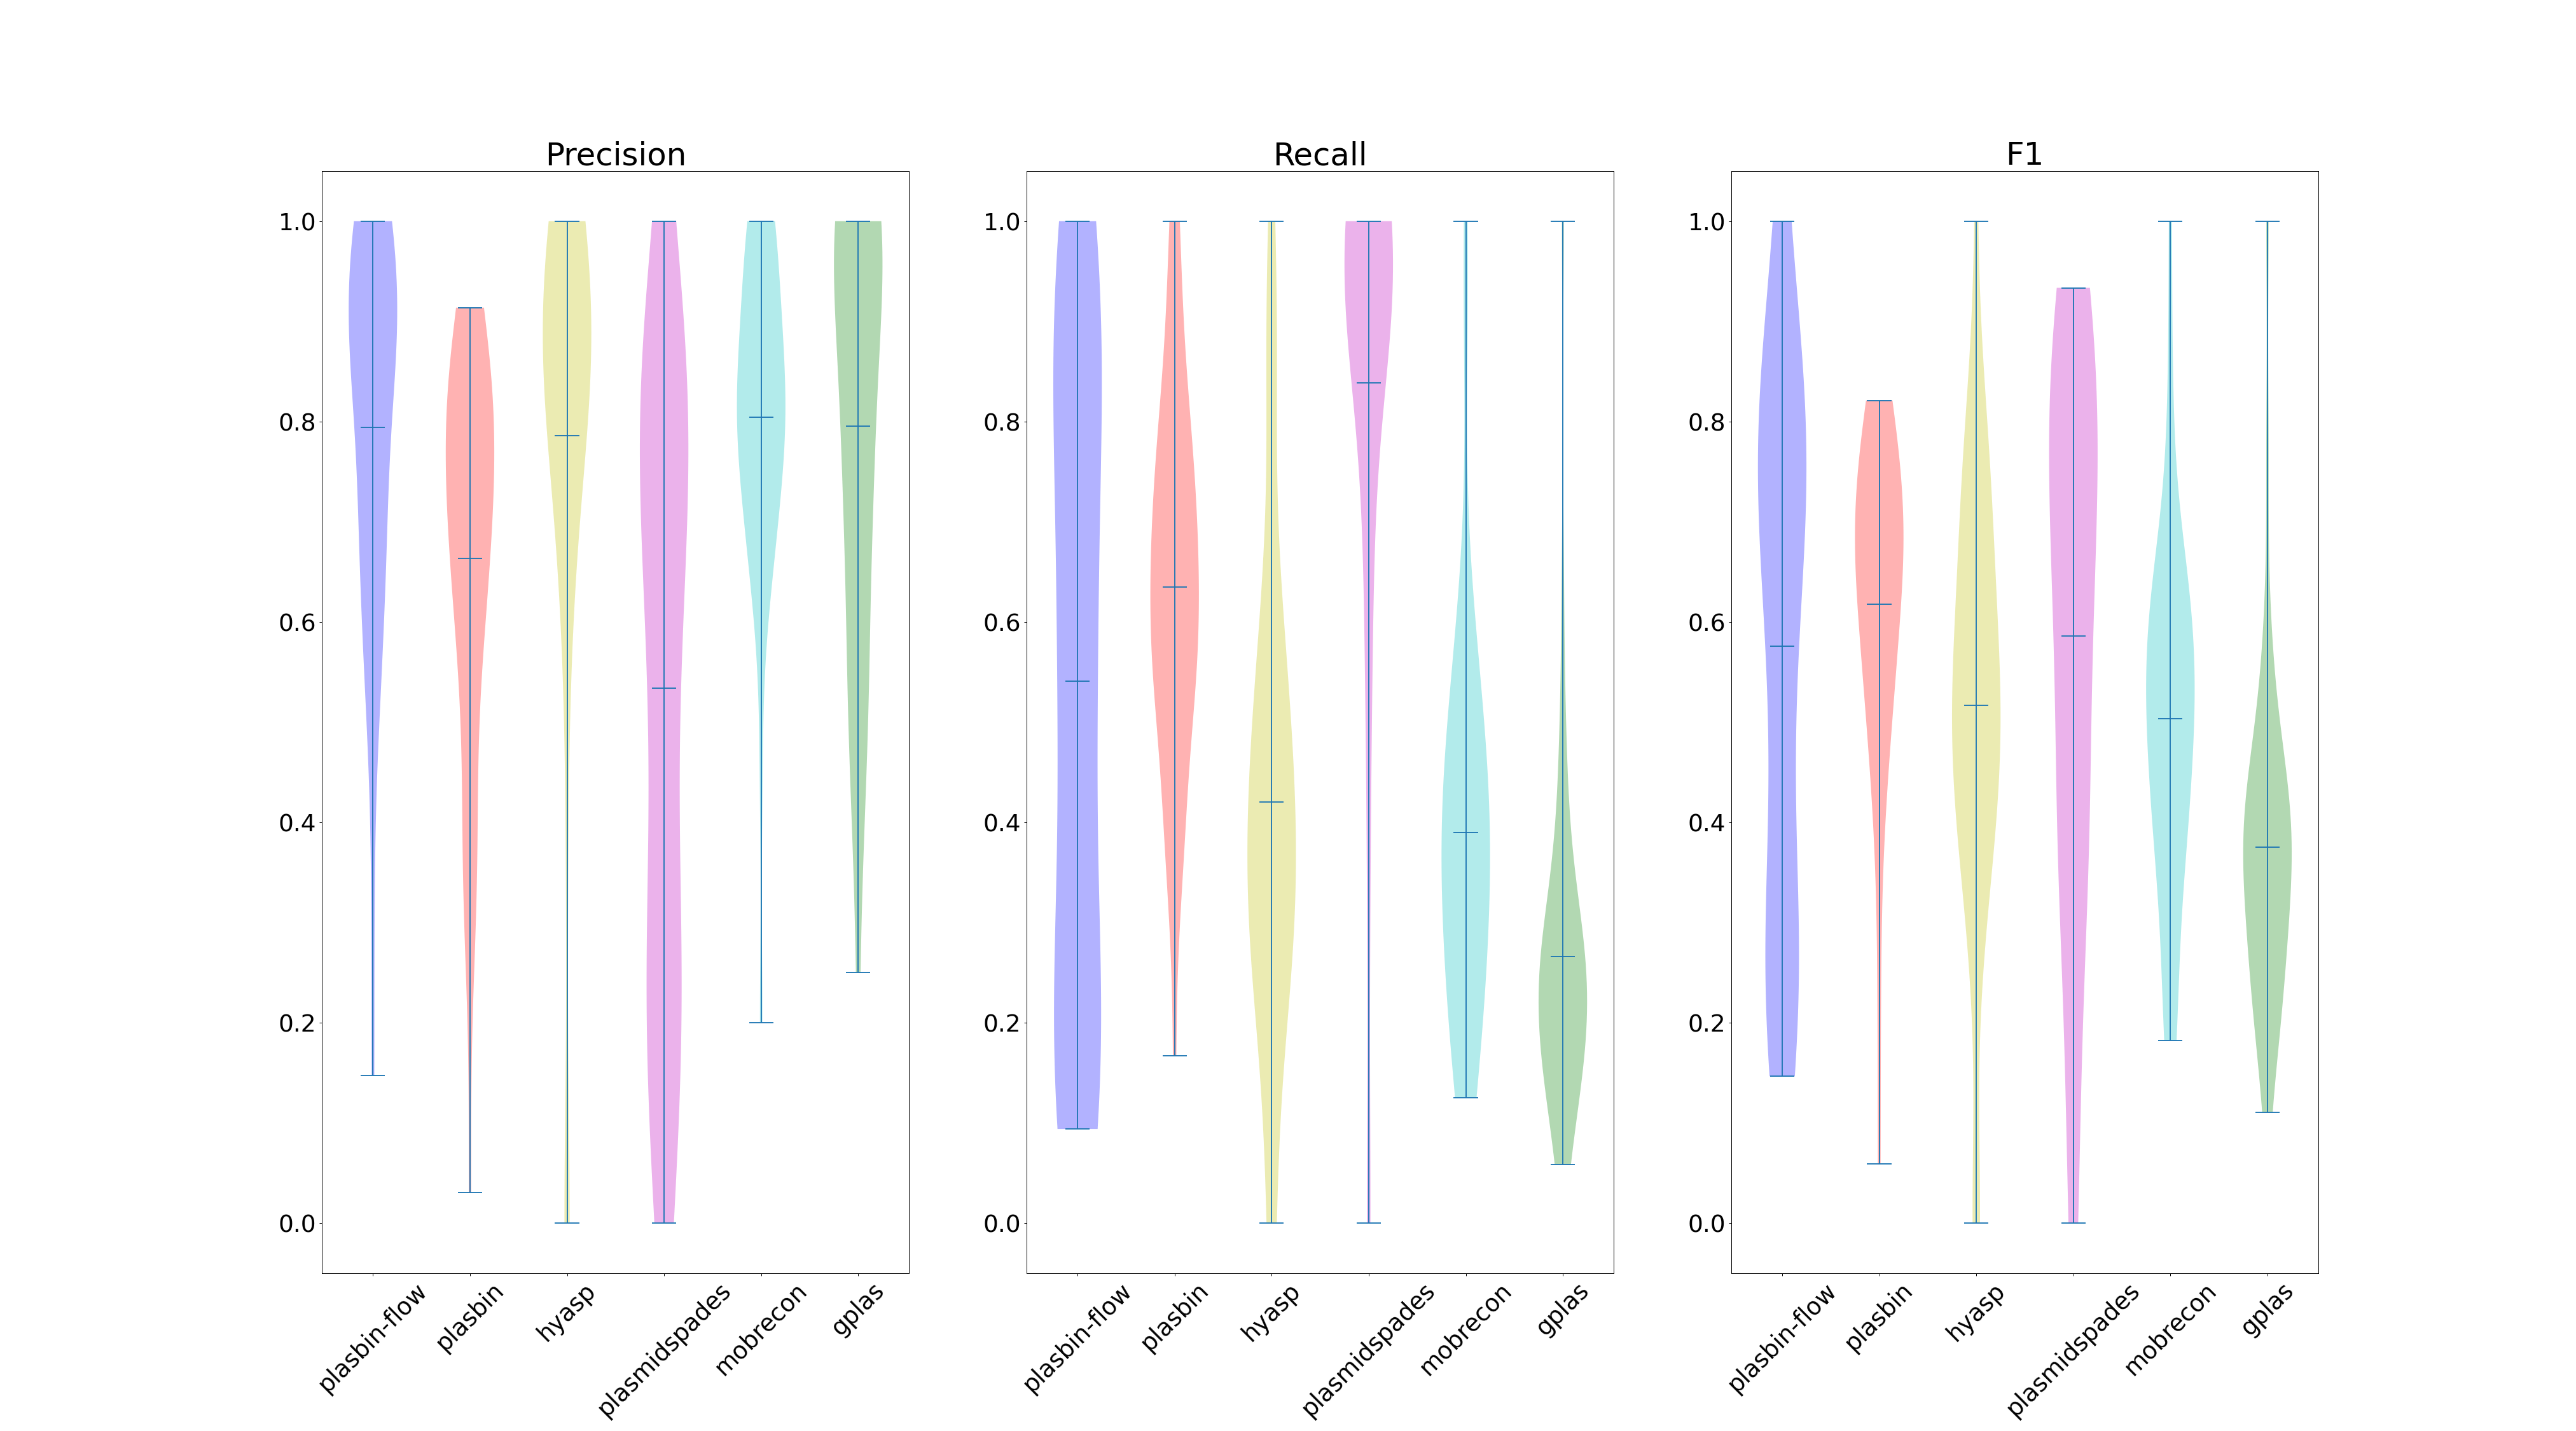

In [190]:
colors = ['b', 'r', 'y', 'm', 'c','g']
labels = ['plasbin-flow', 'plasbin', 'hyasp','plasmidspades','mobrecon', 'gplas']
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(45, 25))
bplot1 = ax1.violinplot(TS_DF[[ 'Precision_by_nctg', 'plasbin_Prec_by_nctg','greedy_Prec_by_nctg', 'plasmidspades_Prec_by_nctg','mobrecon_Prec_by_nctg', 'gplas_Prec_by_nctg']], showmeans=True)
ax1.set_title('Precision',fontsize=40)

bplot2 = ax2.violinplot(TS_DF[['Recall_by_nctg', 'plasbin_Rec_by_nctg','greedy_Rec_by_nctg','plasmidspades_Rec_by_nctg', 'mobrecon_Rec_by_nctg', 'gplas_Rec_by_nctg']], showmeans=True)
ax2.set_title('Recall',fontsize=40)
bplot3 = ax3.violinplot(TS_DF[['F1_by_nctg', 'plasbin_F1_by_nctg','greedy_F1_by_nctg', 'plasmidspades_F1_by_nctg','mobrecon_F1_by_nctg', 'gplas_F1_by_nctg']], showmeans=True)
ax3.set_title('F1',fontsize=40)

for bplot in (bplot1, bplot2, bplot3):
    for pc, color in zip(bplot['bodies'], colors):
        pc.set_facecolor(color)

for ax in [ax1, ax2, ax3]:
    
    ax.tick_params(axis='x', labelrotation = 45)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.set_xticks([1,2,3,4,5,6])
    ax.set_xticklabels(labels,fontsize=30)
plt.show()
#plt.close()

<IPython.core.display.Javascript object>


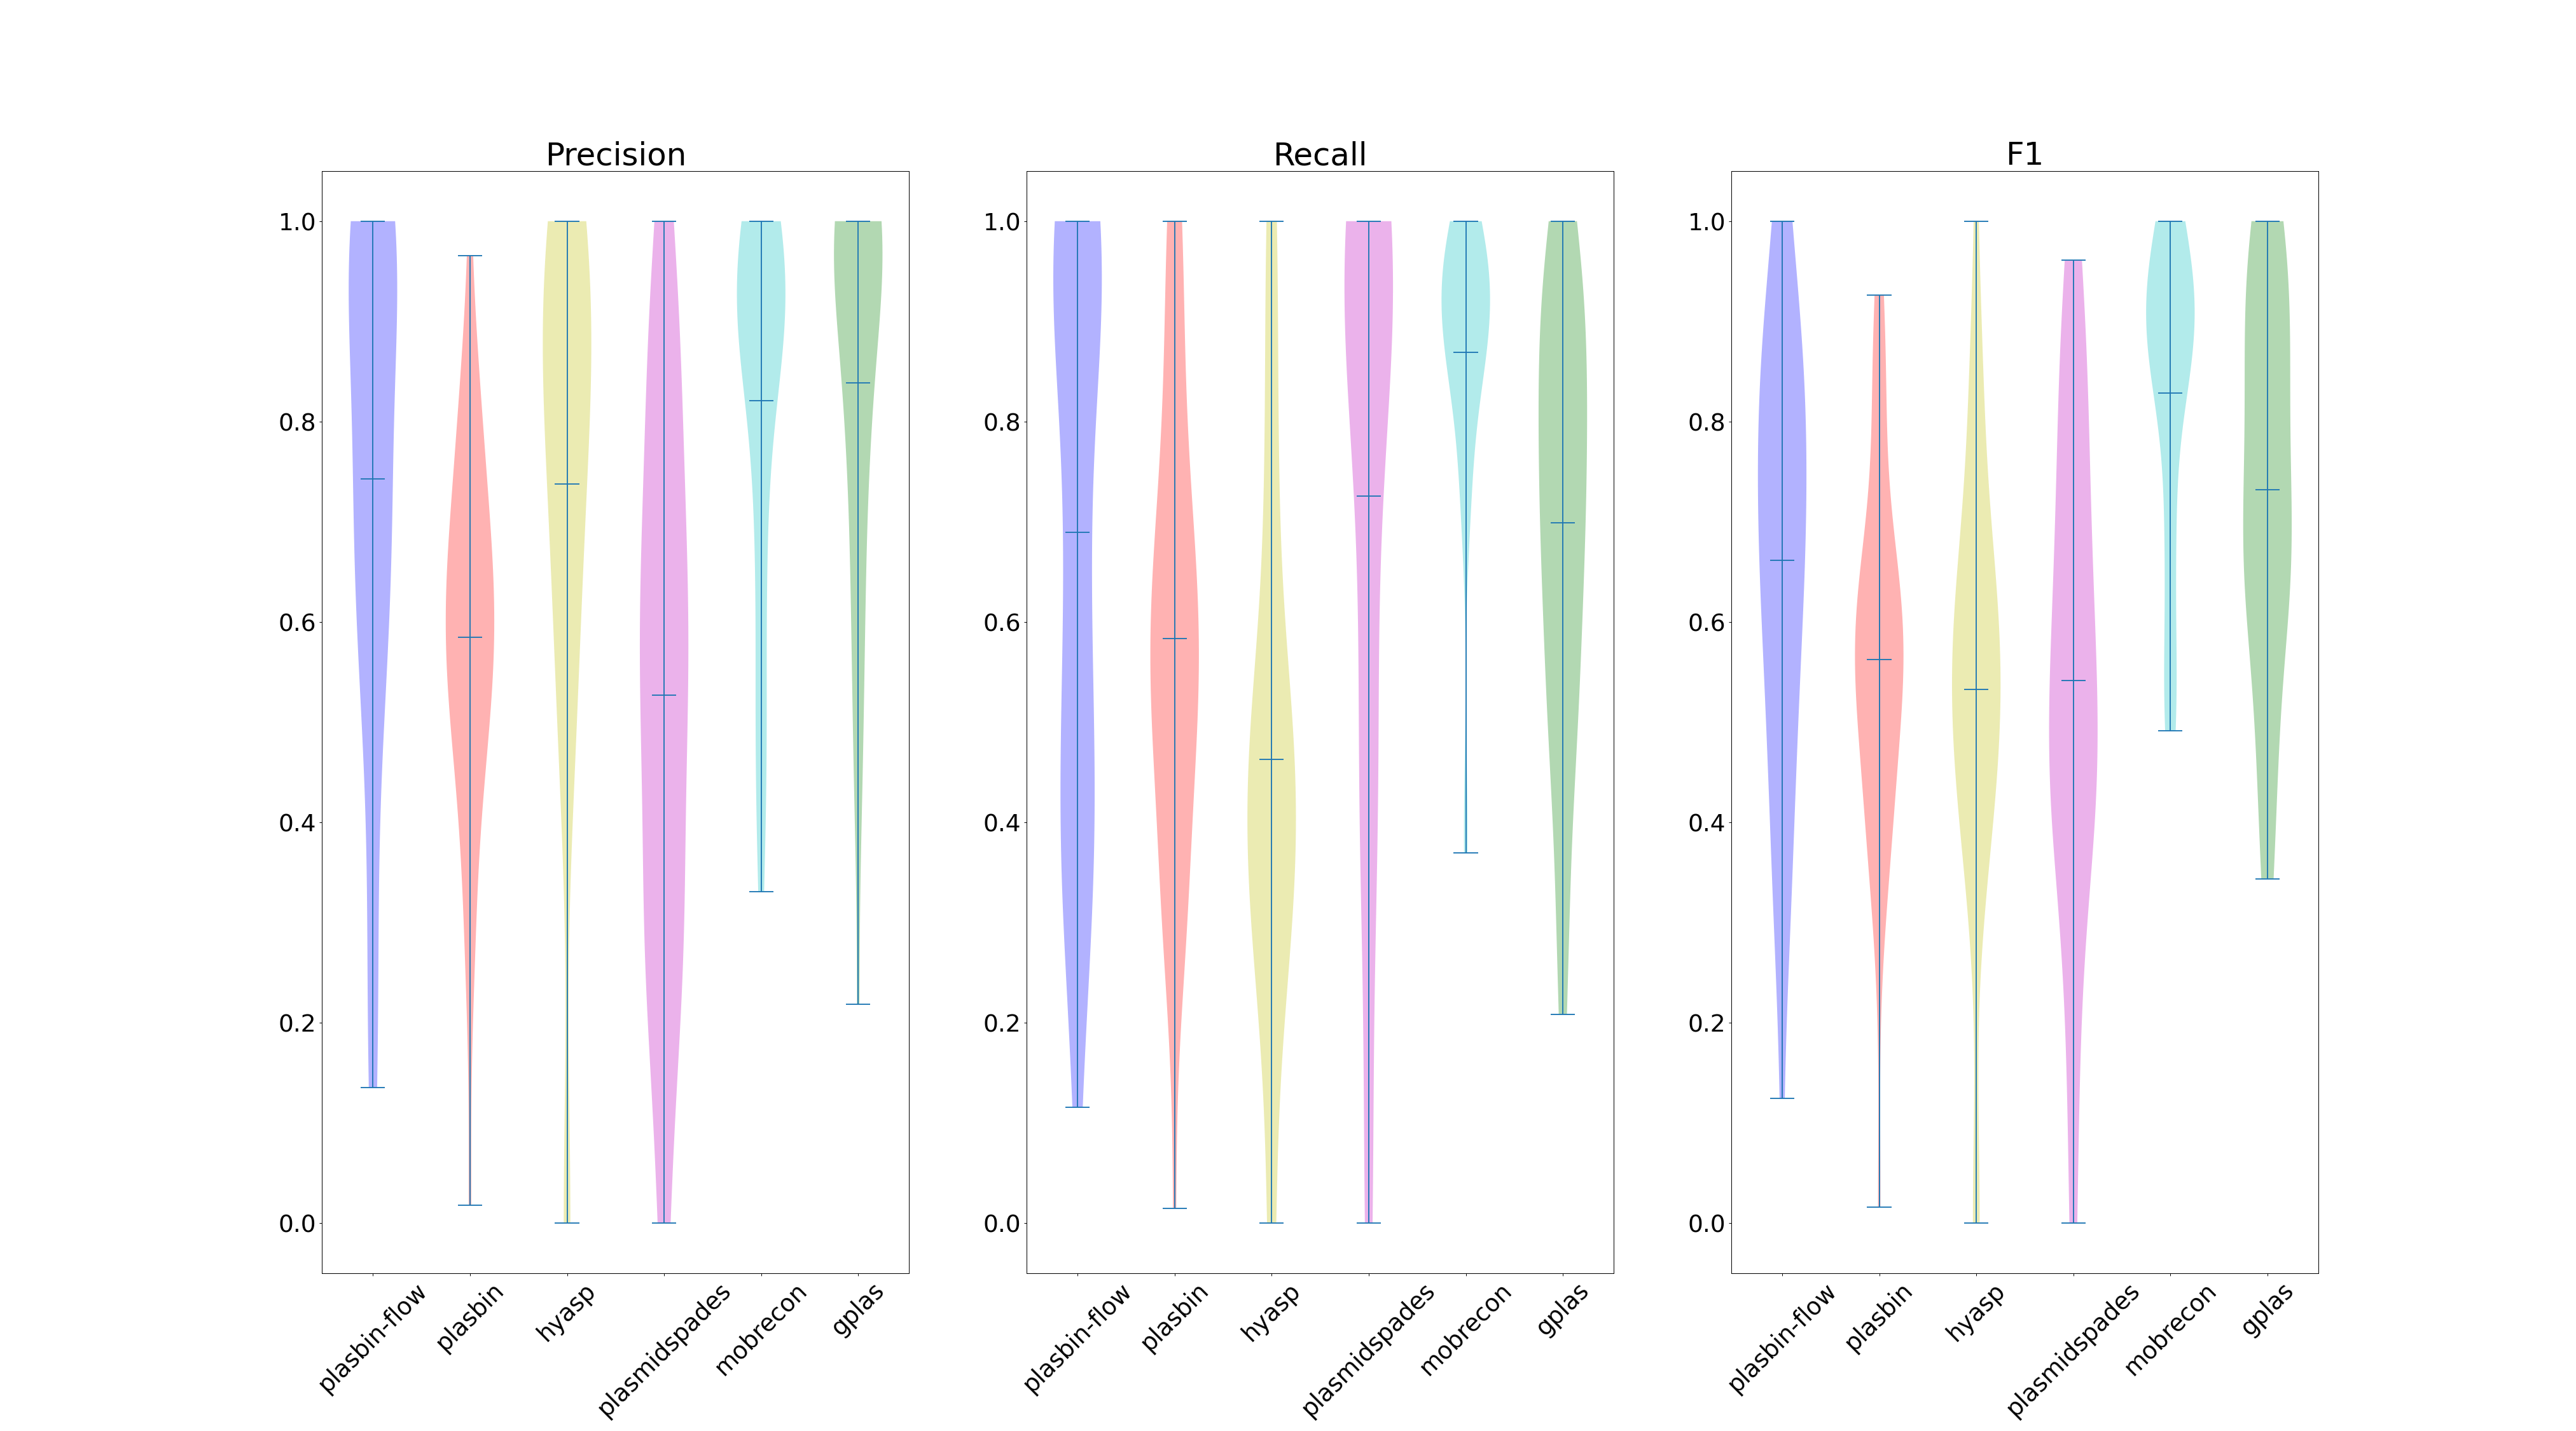

In [191]:
colors = ['b', 'r', 'y', 'm', 'c','g']
labels = ['plasbin-flow', 'plasbin', 'hyasp','plasmidspades','mobrecon', 'gplas']
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(45, 25))
bplot1 = ax1.violinplot(TS_DF[[ 'Precision_by_len', 'plasbin_Prec_by_len','greedy_Prec_by_len', 'plasmidspades_Prec_by_len','mobrecon_Prec_by_len', 'gplas_Prec_by_len']], showmeans=True)
ax1.set_title('Precision',fontsize=40)

bplot2 = ax2.violinplot(TS_DF[['Recall_by_len', 'plasbin_Rec_by_len','greedy_Rec_by_len','plasmidspades_Rec_by_len', 'mobrecon_Rec_by_len', 'gplas_Rec_by_len']], showmeans=True)
ax2.set_title('Recall',fontsize=40)
bplot3 = ax3.violinplot(TS_DF[['F1_by_len', 'plasbin_F1_by_len','greedy_F1_by_len', 'plasmidspades_F1_by_len','mobrecon_F1_by_len', 'gplas_F1_by_len']], showmeans=True)
ax3.set_title('F1',fontsize=40)

for bplot in (bplot1, bplot2, bplot3):
    for pc, color in zip(bplot['bodies'], colors):
        pc.set_facecolor(color)

for ax in [ax1, ax2, ax3]:
    
    ax.tick_params(axis='x', labelrotation = 45)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.set_xticks([1,2,3,4,5,6])
    ax.set_xticklabels(labels,fontsize=30)
plt.show()
#plt.close()

<IPython.core.display.Javascript object>


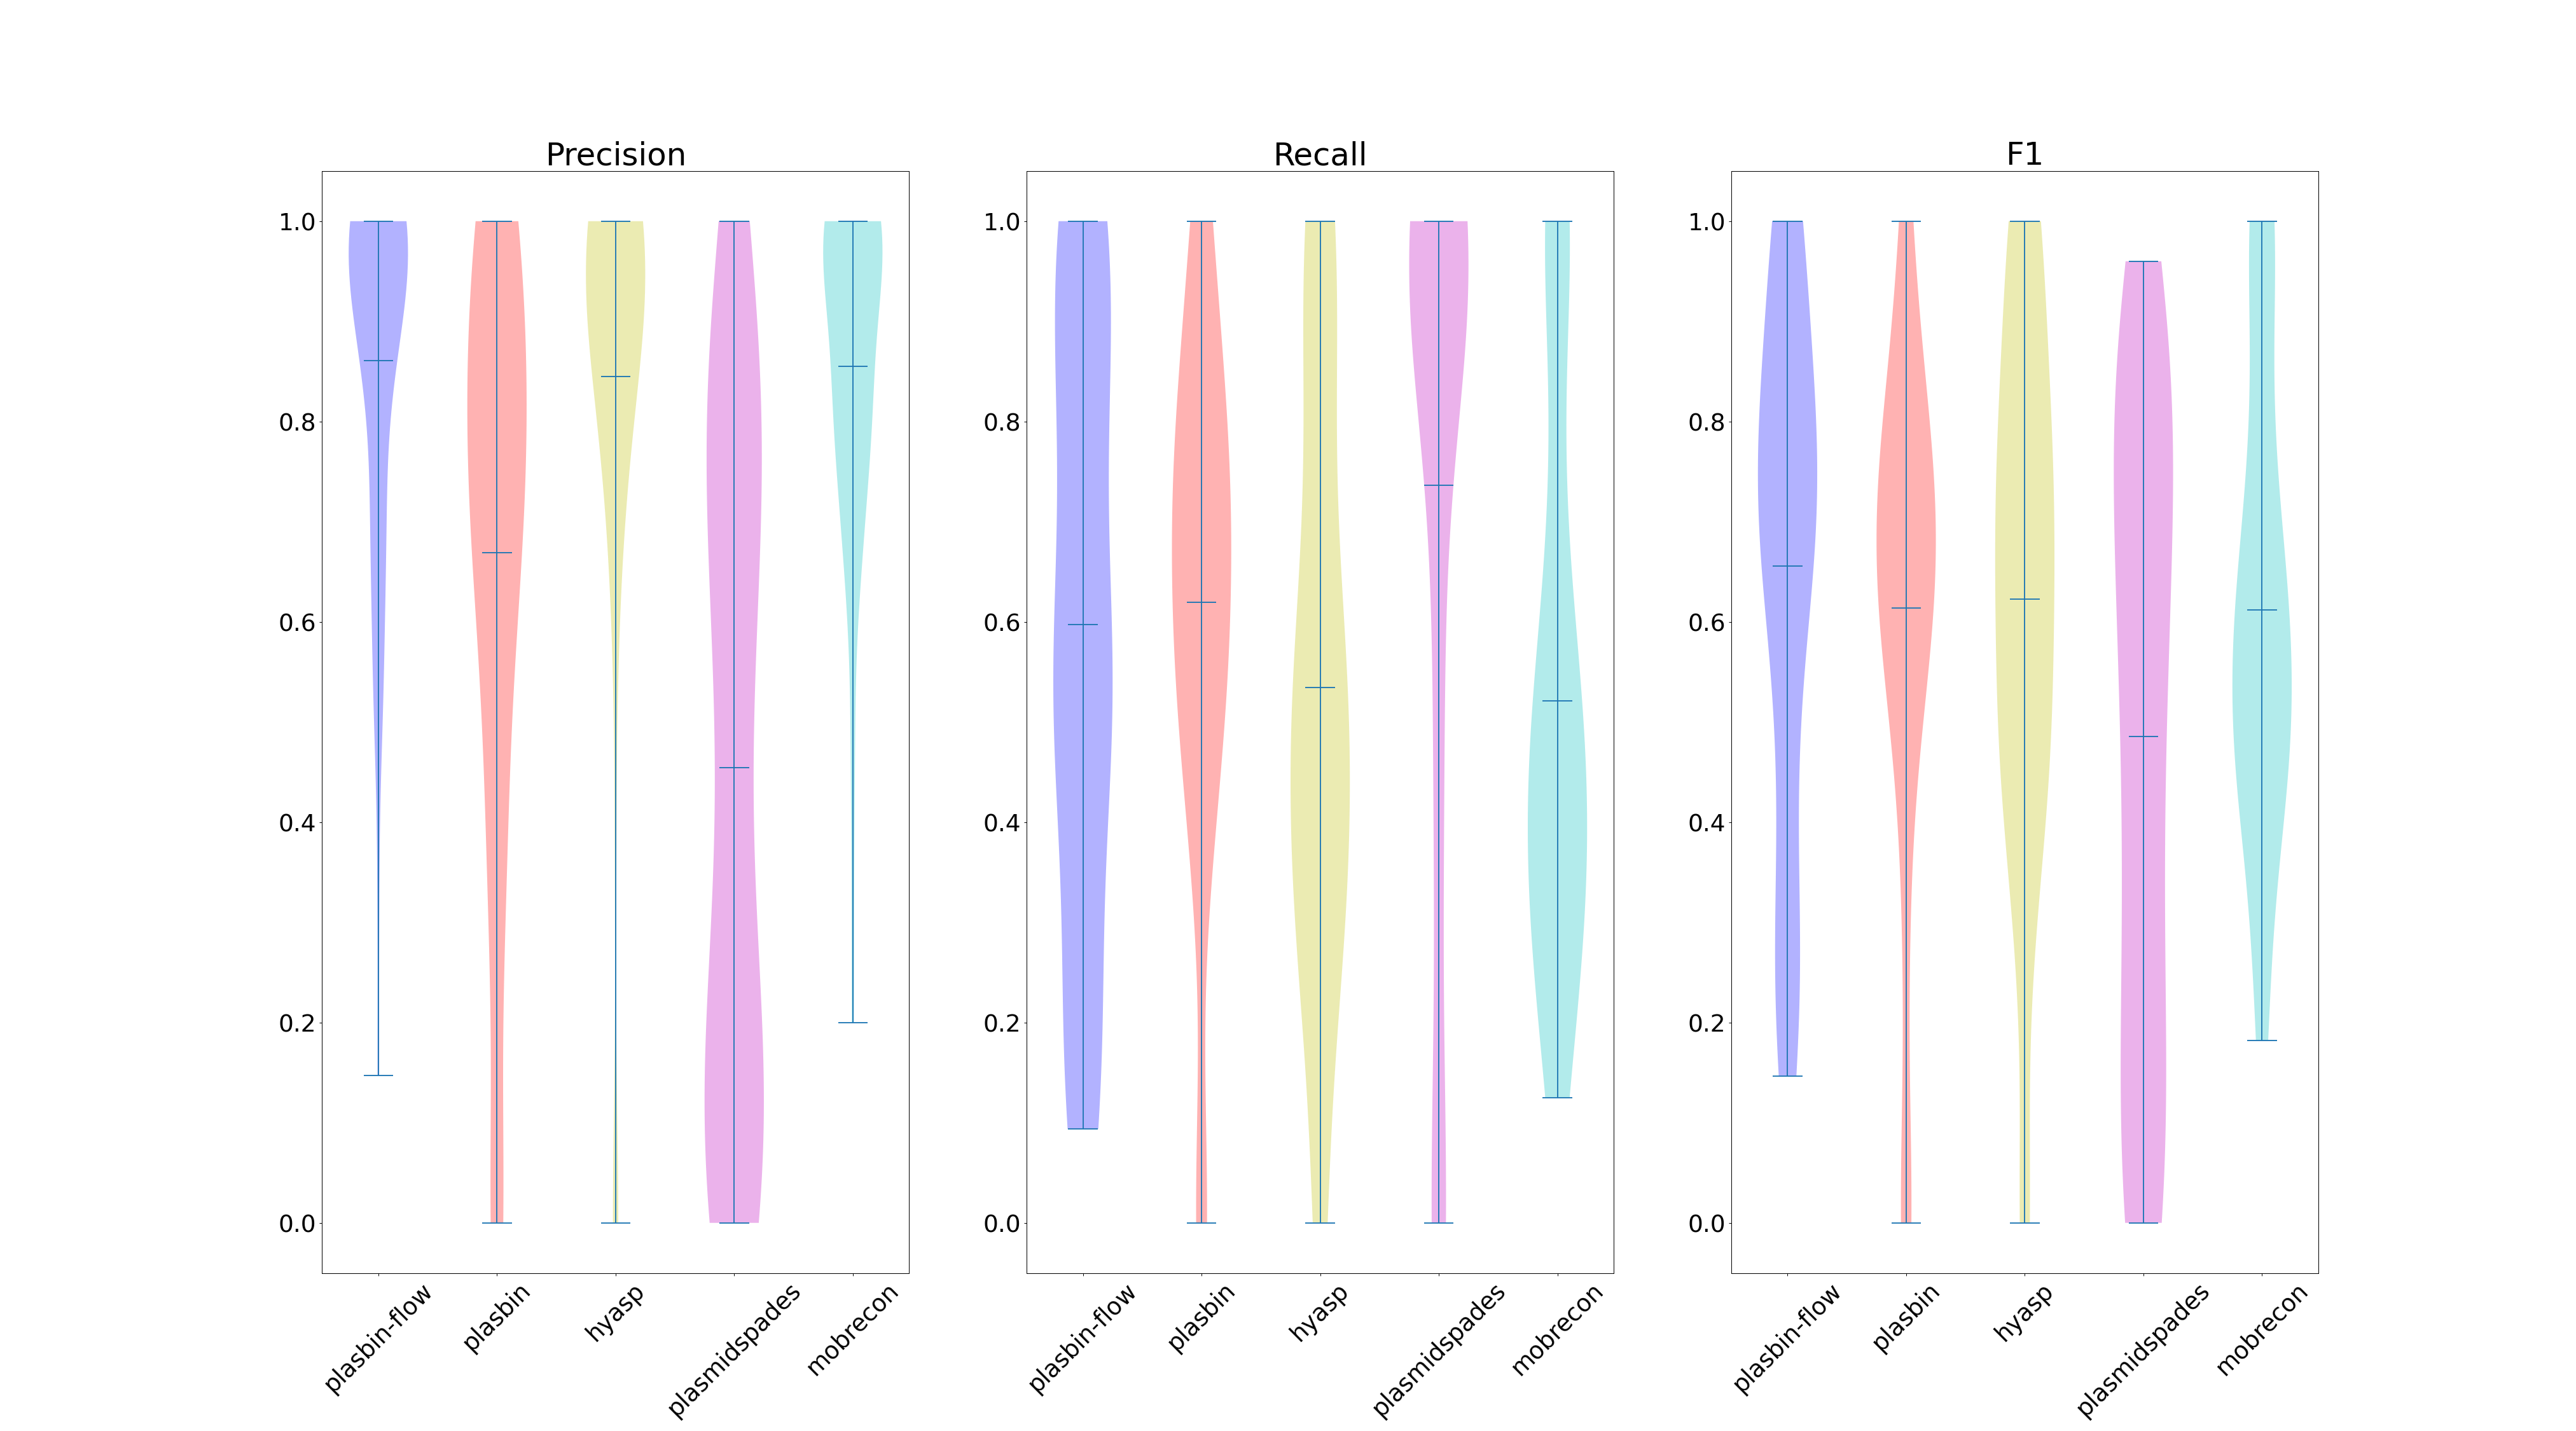

In [192]:
colors = ['b', 'r', 'y', 'm', 'c']
labels = ['plasbin-flow', 'plasbin', 'hyasp','plasmidspades','mobrecon']
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(45, 25))
bplot1 = ax1.violinplot(A_DF[[ 'Precision_by_nctg', 'plasbin_Prec_by_nctg','greedy_Prec_by_nctg', 'plasmidspades_Prec_by_nctg','mobrecon_Prec_by_nctg']], showmeans=True)
ax1.set_title('Precision',fontsize=40)

bplot2 = ax2.violinplot(A_DF[['Recall_by_nctg', 'plasbin_Rec_by_nctg','greedy_Rec_by_nctg','plasmidspades_Rec_by_nctg', 'mobrecon_Rec_by_nctg']], showmeans=True)
ax2.set_title('Recall',fontsize=40)
bplot3 = ax3.violinplot(A_DF[['F1_by_nctg', 'plasbin_F1_by_nctg','greedy_F1_by_nctg', 'plasmidspades_F1_by_nctg','mobrecon_F1_by_nctg']], showmeans=True)
ax3.set_title('F1',fontsize=40)

for bplot in (bplot1, bplot2, bplot3):
    for pc, color in zip(bplot['bodies'], colors):
        pc.set_facecolor(color)

for ax in [ax1, ax2, ax3]:
    
    ax.tick_params(axis='x', labelrotation = 45)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.set_xticks([1,2,3,4,5])
    ax.set_xticklabels(labels,fontsize=30)
plt.show()
#plt.close()

<IPython.core.display.Javascript object>


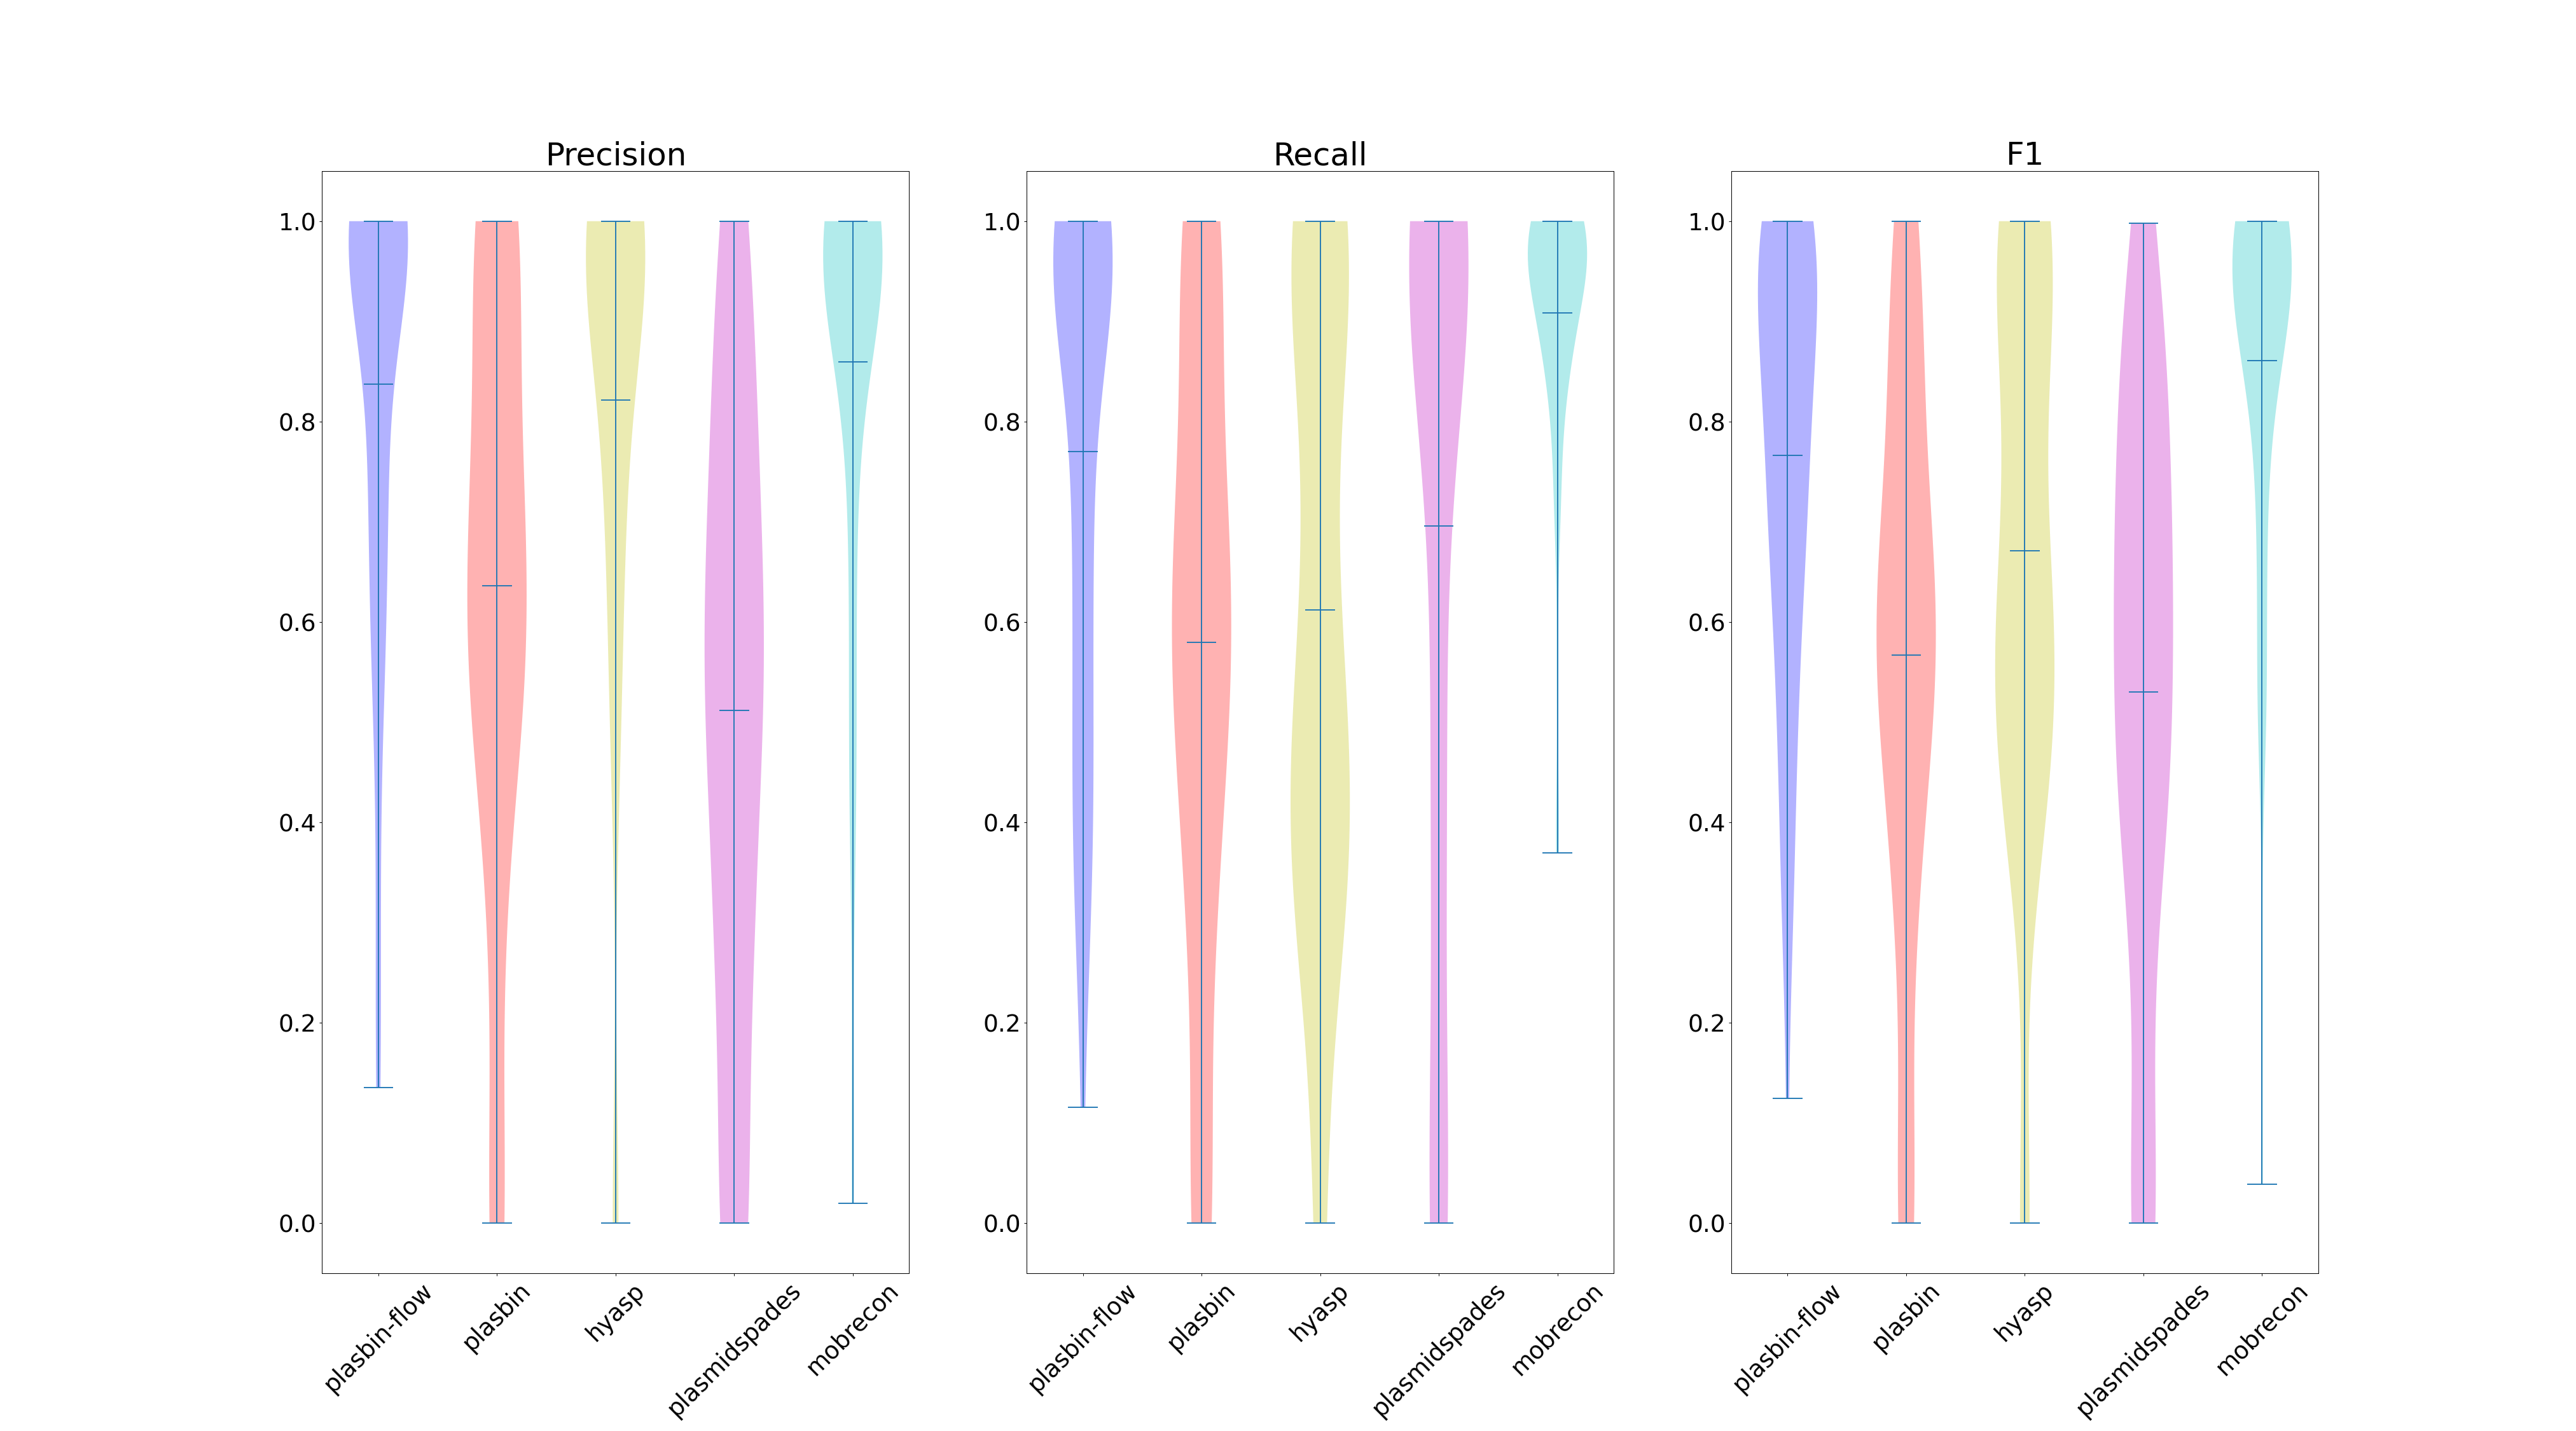

In [193]:
colors = ['b', 'r', 'y', 'm', 'c']
labels = ['plasbin-flow', 'plasbin', 'hyasp','plasmidspades','mobrecon']
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(45, 25))
bplot1 = ax1.violinplot(A_DF[[ 'Precision_by_len', 'plasbin_Prec_by_len','greedy_Prec_by_len', 'plasmidspades_Prec_by_len','mobrecon_Prec_by_len']], showmeans=True)
ax1.set_title('Precision',fontsize=40)

bplot2 = ax2.violinplot(A_DF[['Recall_by_len', 'plasbin_Rec_by_len','greedy_Rec_by_len','plasmidspades_Rec_by_len', 'mobrecon_Rec_by_len']], showmeans=True)
ax2.set_title('Recall',fontsize=40)
bplot3 = ax3.violinplot(A_DF[['F1_by_len', 'plasbin_F1_by_len','greedy_F1_by_len', 'plasmidspades_F1_by_len','mobrecon_F1_by_len']], showmeans=True)
ax3.set_title('F1',fontsize=40)

for bplot in (bplot1, bplot2, bplot3):
    for pc, color in zip(bplot['bodies'], colors):
        pc.set_facecolor(color)

for ax in [ax1, ax2, ax3]:
    
    ax.tick_params(axis='x', labelrotation = 45)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.set_xticks([1,2,3,4,5])
    ax.set_xticklabels(labels,fontsize=30)
plt.show()